# Matrix decomposition


In [5]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.spatial import distance
import seaborn as sns
from sklearn.decomposition import FastICA, PCA 

sns.set(style='white', context='notebook')

%matplotlib inline



### Matrix decomposition methods: PCA and ICA

The two first methods we will talk about are true matrix decomposition methods. They are trying to decompose a matrix $X$ into constitutent parts, $Y$ and $W$.

$Y = WX$

These matrix equations may be kind of intimidating so one way to think about them adding the signal from genes:

$
\text{Component }1 = 10\text{gene}_1 - 50\text{gene}_2 + 2\text{gene}_3 \ldots
$

Depending on the algorithm the coefficients will have different constraints (have to sum to one or be independent or something annoying like that) but the idea is the same: summarize the gene expression (features) into fewer components, each of which are linear combinations of the original genes (features).

## Principal Component Analysis (PCA)

Conceptually speaking, PCA is a rotation of the data:

![](figures/pca_unrotated.png)
![](figures/pca_rotation.png)

Principal component analysis, statistically speaking, finds the axes of most variance in the data. Put another way, PCA finds the directions of genes that change the most across your data, then the second most changing genes, then the next.

PCA decomposes your data matrix with the constraint that the first component must "explain" the majority of the data. What does "explain" really mean here?

![](figures/pca.png)

Source: http://www.nlpca.org/pca_principal_component_analysis.html

What "explain" means is that the first axis represents the direction of the data that varies the most. PCA assumes that low variance means noise. 


Let's take the first component first. The data is projected onto a line for the first component that minimizes the distance between points from the first component line:

![](figures/pca_distance_from_line.jpg)

source: https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/

### Side note: Kernel PCA

Kernel PCA is best used on non-linear data. Kernel PCA means that you did a "kernel transformation" - usually a ["radial basis function"](https://en.wikipedia.org/wiki/Radial_basis_function) on the data to force it to be linear beforehand:

![](figures/plot_kernel_pca_001.png)

## Independent Component Analysis (ICA)

ICA was originally created for the "cocktail party problem" for audio processing. It's an incredible feat that our brains are able to filter out all these different sources of audio, automatically!

![](figures/Cocktail-party-_2502341b.jpg)
(I really like how smug that guy looks - it's really over the top)
[Source](http://www.telegraph.co.uk/news/science/science-news/9913518/Cocktail-party-problem-explained-how-the-brain-filters-out-unwanted-voices.html)

### Cocktail party problem

Given multiple sources of sound (people talking, the band playing, glasses clinking), how do you distinguish independent sources of sound? Imagine at a cocktail party you have multiple microphones stationed throughout, and you get to hear all of these different sounds. 

![](figures/independent-component-analysis-ica-the-cocktail-party-problem-n.jpg)

[Source](http://www.slideserve.com/vladimir-kirkland/ica-and-isa-using-schweizer-wolff-measure-of-dependence)

### What if you applied PCA to the cocktail party problem?

What would you get if you 

Example adapted from the excellent [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html).

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


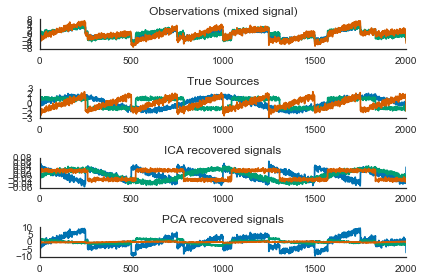

In [6]:

###############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = sns.color_palette('colorblind')

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
sns.despine()
plt.show()


### Quiz 2.3.1

[Link](https://docs.google.com/forms/d/1D3D1IE7q6cqpX7isW9-EIIDH5ixKkLOUzSlKyno1n2I/viewform)

## PCA vs ICA

Which one should you use? Well, that depends on your question :)

PCA and ICA have different goals. PCA wants to find the things that change the greatest across your data, and ICA wants to find individual signals. Let's take a look at this by running both PCA and ICA on data that we're all familiar with - faces!

The "Olivetti Faces Dataset" is a commonly use face recognition dataset in machine learning.

Dataset consists of 400 faces


/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


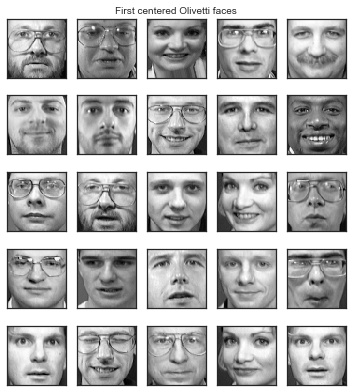

In [7]:
# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition


image_shape = (64, 64)
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

###############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)





###############################################################################
def plot_gallery(title, images, n_col=5, n_row=5, cmap=plt.cm.viridis):
    plt.figure(figsize=(2. * n_col/2, 2.26 * n_row/2))
    plt.suptitle(title)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        if comp.min() < 0:
            vmax = max(comp.max(), -comp.min())
            vmin = -vmax
        else:
            vmin = comp.min()
            vmax = comp.max()
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=vmin, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

    
    

###############################################################################
# Plot a sample of the input data



plot_gallery("First centered Olivetti faces", faces[:25], cmap=plt.cm.gray)


The first figure and its subpanels show the first 20 (out of 400) faces in the dataset. 

So now let's explore!

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


done in 0.278s


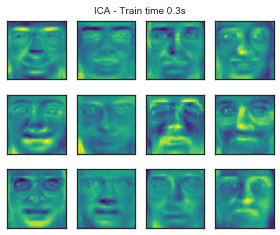

In [8]:
def explore_pca_ica(algorithm, n_components):
    
    # establish size of the figure to plot by the number
    # of rows and columns of subplots
    n_row = 1
    n_col = 1
    while n_row * n_col < n_components:
        if n_col > n_row:
            n_row += 1
        else:
            n_col += 1
            
    
    kwargs = dict(whiten=True, n_components=n_components)
    if algorithm == 'PCA':
        decomposer = PCA(**kwargs)
    elif algorithm == 'ICA':
        kwargs['random_state'] = 2016
        kwargs['max_iter'] = 200
        kwargs['tol'] = 0.001
        decomposer = FastICA(**kwargs)
    
    t0 = time()
    decomposer.fit(X=faces_centered)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    
    plot_gallery('%s - Train time %.1fs' % (algorithm, train_time),
                 decomposer.components_[:n_components], n_col=n_col, n_row=n_row)


ipywidgets.interact(explore_pca_ica,
                   algorithm=ipywidgets.Dropdown(options=['PCA', 'ICA'], value='PCA',
                                                  description='Matrix decomposition algorithm'),
                   n_components=ipywidgets.IntSlider(min=2, max=50, value=12));


This plot shows you the *components* of the data. 

Notice that in PCA, these are "eigenfaces," that is, the first face is the most average face that explains most of the data. The next components shows where the next largest amount of variance is. As you continue, the components of PCA goes into the edge cases of the different faces so you can reconstruct more and more faces.

For ICA, we don't get an "eigenface." Instead, ICA goes right into the discrete signals. Notice that some of the ICA components actually look like an individual person's face, not an average of people's faces. ICA is pulling out individual people who had their photo taken multiple times in the dataset, and reconstructing them.

### Quiz 2.3.2

Work on this [quiz](https://docs.google.com/forms/d/1Tj2mwbOAMQlsEM_tx1ZtC4ahvbqgfjjoWXuwOOO788c/viewform) while you play with the sliders above.

#### The punchline

Which should you use, PCA or ICA? Again, it depends on your question!

PCA tells you which are the largest varying genes in your data. ICA tells you which genes contribute to discrete signals from specific populations in your data.